<a href="https://colab.research.google.com/github/100495982/ML_G84_Grupo2/blob/main/primera_pr%C3%A1ctica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Primera Práctica**

**Autores:**


---


Luis Enrique Valero Montero - Gr. 85 - 100495982

Isabelle Borgstedt - Gr. 84 - 100559990

# EDA Simplificado

Things to add to the EDA:
- Distribution graphs
- Outlier detection and analysis
- Covariance
- Median, min, max, and average of important attributes

We can always keep adding more to this later.

In [101]:
import pandas as pd
from tabulate import tabulate
df = pd.read_csv("attrition_availabledata_09.csv")

# ¿Cuántas variables e instancias hay?
print("Hay " + str(df.shape[0]) + " instancias y " + str(df.shape[1]) + " variables.")
print("-------------------------------------------------------------------------------------------------------------------------------------")

# ¿Qué variables son categóricas/ordinales/númericas?
cat_var = df.select_dtypes(include=['object']).columns.tolist()

def ordinales_o_numericas(df, threshold=5):
  num_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
  ord_var = []

  for col in num_var:
    unique_values = df[col].nunique()
    if unique_values <= threshold:
      ord_var.append(col)
    num_var = [x for x in num_var if x not in ord_var]
  return num_var, ord_var

print("Variables categóricas: ", cat_var)
print("Variables ordinales: ", ordinales_o_numericas(df)[1])
print("Variables numéricas: ", ordinales_o_numericas(df)[0])
print("-------------------------------------------------------------------------------------------------------------------------------------")

#corr_matrix = df.corr()
#print("Matriz de correlación: ")
#print(corr_matrix)
#print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Hay variables categóricas con alta cardinalidad?
def cardinalidad(df):
  cat_var = df.select_dtypes(include=['object']).columns.tolist()
  cardinalidad = {col: df[col].nunique() for col in cat_var}
  cardinalidad_df = pd.DataFrame(list(cardinalidad.items()), columns=['Variable', 'Unique Values'])
  cardinalidad_df = cardinalidad_df.sort_values(by="Unique Values", ascending=False)
  return cardinalidad_df

print("Variables con alta cardinalidad: ")
cardinalidad_df = cardinalidad(df)
print(cardinalidad_df)
print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Qué variables tienen valores faltantes y cuántos?
def faltantes(df):
  datos_faltantes = df.isnull().sum()
  datos_faltantes = datos_faltantes[datos_faltantes > 0]
  faltantes_df = pd.DataFrame({
      "Variable:": datos_faltantes.index,
      "Valores faltantes:": datos_faltantes.values,
      "Porcentaje faltantes:": datos_faltantes.values / len(df) * 100
  })
  faltantes_df = faltantes_df.sort_values(by="Porcentaje faltantes:", ascending=False)
  return faltantes_df

print("Variables con valores faltantes: ")
faltantes_df = faltantes(df)
print(faltantes_df)
print("-------------------------------------------------------------------------------------------------------------------------------------")

# ¿Hay columnas constantes o columnas de ID?
def constantes(df):
  constantes = []
  for col in df.columns:
    if df[col].nunique() == 1:
      constantes.append(col)
  return constantes

print("Columnas constantes: ", constantes(df))

def id(df):
  id_cols = []
  for col in df.columns:
    if df[col].nunique() == len(df):
      id_cols.append(col)
  return id_cols

print("Columnas de ID: ", id(df))
print("-------------------------------------------------------------------------------------------------------------------------------------")


# ¿Se trata de un problema de regresión o clasificación?
print("Se trata de un problema de clasificación porque el attributo'Attrition' tiene dos posibles valores categoricos discretos: Sí o No.")
print("-------------------------------------------------------------------------------------------------------------------------------------")


# Si es clasificación, ¿está desbalanceado?
print(df["Attrition"].value_counts(normalize=True))
print("Está desbalanceado.")
print("-------------------------------------------------------------------------------------------------------------------------------------")


# Definir variables numéricas
numerical_vars, ordinal_vars = ordinales_o_numericas(df)

print("Estadísticas descriptivas para las variables numéricas:")
df_num_desc = df[numerical_vars].describe().transpose().round(2)  # Transpose for readability & round to 2 decimals
df_num_desc.insert(0, "Variable", df_num_desc.index)  # Add column for variable names
print(tabulate(df_num_desc, headers='keys', tablefmt='pretty', showindex=False))  # Print as a formatted table


print("Análisis descriptivo para las variables categóricas:")
for col in cat_var:
    print(f"\nDistribución de {col}:")
    df_cat = df[col].value_counts(normalize=True).mul(100).round(2).reset_index()  # Round to 2 decimal places
    df_cat.columns = [col, 'Percentage']
    print(tabulate(df_cat, headers='keys', tablefmt='pretty', showindex=False))


Hay 2940 instancias y 31 variables.
-------------------------------------------------------------------------------------------------------------------------------------
Variables categóricas:  ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Variables ordinales:  ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Education', 'EmployeeCount', 'JobLevel', 'StandardHours', 'StockOptionLevel']
Variables numéricas:  ['hrs', 'absences', 'Age', 'DistanceFromHome', 'EmployeeID', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
-------------------------------------------------------------------------------------------------------------------------------------
Variables con alta cardinalidad: 
         Variable  Unique Values
4         JobRole            

Vamos a encontrar "outliers" para determinar las mejores opciones para escalado y imputación.


Outliers using Z-Score:
                   Column  Outlier Index   Z-Score
0       TotalWorkingYears             50  3.248904
1       TotalWorkingYears            185  3.122043
2       TotalWorkingYears            248  3.122043
3       TotalWorkingYears            292  3.122043
4       TotalWorkingYears            386  3.122043
..                    ...            ...       ...
168  YearsWithCurrManager           2293  3.554717
169  YearsWithCurrManager           2414  3.554717
170  YearsWithCurrManager           2424  3.554717
171  YearsWithCurrManager           2583  3.001849
172  YearsWithCurrManager           2731  3.001849

[173 rows x 3 columns]

Outliers using IQR Method:
                    Column  Outlier Index  IQR Method
0                      hrs             12   10.666170
1                      hrs             25   10.389476
2                      hrs             51   10.433987
3                      hrs             64   10.907255
4                      hrs            214

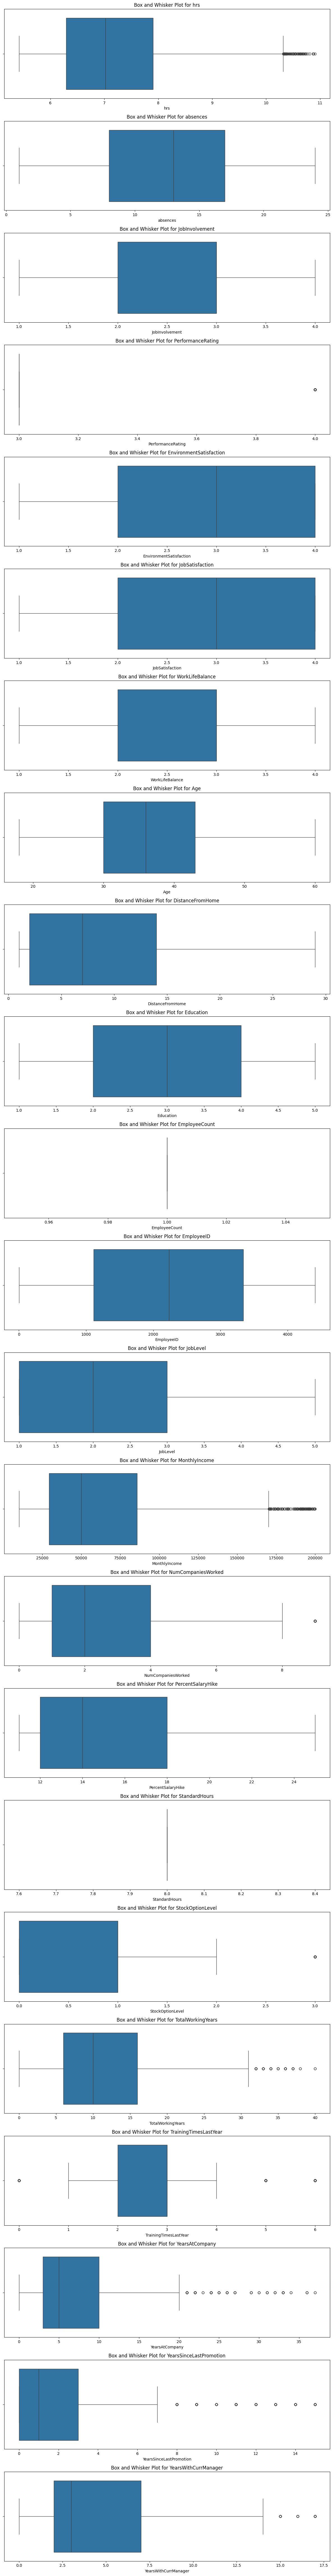

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Detecting Outliers using Z-Score
def zscore_outliers(df, threshold=3):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outliers_list = []  # Store outliers in a list

    for col in numerical_cols:
        z_scores = zscore(df[col].dropna())  # Calculate Z-scores
        outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
        outlier_values = df[col].iloc[outlier_indices]
        for idx, value in zip(outlier_indices, outlier_values):
            outliers_list.append({"Column": col, "Outlier Index": idx, "Z-Score": z_scores[idx]})

    outliers = pd.DataFrame(outliers_list)
    return outliers

# Detecting Outliers using IQR
def iqr_outliers(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    outliers_list = []  # Store outliers in a list

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_values = df[col].loc[outlier_indices]

        for idx, value in zip(outlier_indices, outlier_values):
            outliers_list.append({"Column": col, "Outlier Index": idx, "IQR Method": value})

    outliers = pd.DataFrame(outliers_list)
    return outliers

# Find outliers using Z-Score
outliers_zscore = zscore_outliers(df)
print("\nOutliers using Z-Score:")
print(outliers_zscore)

# Find outliers using IQR Method
outliers_iqr = iqr_outliers(df)
print("\nOutliers using IQR Method:")
print(outliers_iqr)

# Box and Whisker Plot for Outliers Visualization
def plot_boxplots(df):
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    plt.figure(figsize=(12, len(numerical_cols) * 4))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols), 1, i)
        sns.boxplot(x=df[col])
        plt.title(f'Box and Whisker Plot for {col}')
        plt.xlabel(col)

    plt.tight_layout()
    plt.show()

# Plot boxplots for all numerical attributes
plot_boxplots(df)

# Preproceso

In [103]:
# Quitar los parámetros constantes y únicos
constantes_cols = constantes(df)
id_cols = id(df)

# Combinar las columnas para dejar y dejarlas
columns_to_drop = constantes_cols + id_cols

# Eliminar las columnas
df = df.drop(columns=columns_to_drop)

# Imprimir las columnas que se quedan
print("Remaining columns: ", df.columns)

Remaining columns:  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object')


# Evaluacion de Rendimiento Futuro

Aquí estamos separando los datos con Holdout: 2/3 train y 1/3 test. Debemos garantizar que los datos para "test" solo son usados para el rendimiento final.

Es importante que mantengamos el balance cuando dividimos los datos: 83.9% "no" y 16.1% "yes".

In [132]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report

def evaluate_model_train(model, X_train, y_train):
    """
    Evaluates a model using Balanced Accuracy, TPR, TNR, and a confusion matrix on training data.
    """
    y_pred = model.predict(X_train)  # Get predictions

    # Compute metrics using y_train (training data)
    balanced_acc = balanced_accuracy_score(y_train, y_pred)  # Corrected to use y_train
    overall_acc = accuracy_score(y_train, y_pred)  # Corrected to use y_train
    cm = confusion_matrix(y_train, y_pred)  # Corrected to use y_train

    # Extract TPR (Sensitivity) and TNR (Specificity)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # Sensitivity (Recall for positive class)
    tnr = tn / (tn + fp)  # Specificity

    # Print results
    print(f"Balanced Accuracy (Train): {balanced_acc:.4f}")
    print(f"Overall Accuracy (Train): {overall_acc:.4f}")
    print(f"True Positive Rate (TPR) (Train): {tpr:.4f}")
    print(f"True Negative Rate (TNR) (Train): {tnr:.4f}")
    print("\nConfusion Matrix (Train):")
    print(cm)
    print("\nClassification Report (Train):")
    print(classification_report(y_train, y_pred))  # Corrected to use y_train


# Metodos Basicos: KNN y Trees

KNN:

Trees:

Vamos a empezar con los métodos de escalado y imputación. Elegimos imputación usando la mediana y escalado usando RobustScaler porque tenemos outliers. También medimos el tiempo de entrenar el modelo.

In [133]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import metrics

# Define target variable and features
target = "Attrition"  # Make sure this column name matches your dataset
X = df.drop(columns=[target])  # Features
y = df[target]  # Target variable

# One-Hot Encoding: Convert categorical variables into numerical values
X_encoded = pd.get_dummies(X, drop_first=True)  # Avoids multicollinearity

# Convert boolean columns to float (before imputing)
X_encoded = X_encoded.astype(float)

# Imputation: Handle missing values with the median strategy
num_imputer = SimpleImputer(strategy="median")
X_encoded = pd.DataFrame(num_imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# Scaling: Use RobustScaler (good for handling outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Convert back to DataFrame after scaling
X_scaled = pd.DataFrame(X_scaled, columns=X_encoded.columns)
df_processed = X_scaled.copy()

# Train/Test Split (Now y is properly defined)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=1/3, stratify=y, random_state=559990)

# Train the Decision Tree with default hyperparameters and measure the training time
start_time = time.time()
model = DecisionTreeClassifier(random_state=559990)
model.fit(X_train, y_train)
end_time = time.time()

# Training time
training_time = end_time - start_time
print(f"Training time (default hyperparameters): {training_time:.4f} seconds")

# Evaluate the model on test data
evaluate_model_train(model, X_train, y_train)


Training time (default hyperparameters): 0.0239 seconds
Balanced Accuracy (Train): 1.0000
Overall Accuracy (Train): 1.0000
True Positive Rate (TPR) (Train): 1.0000
True Negative Rate (TNR) (Train): 1.0000

Confusion Matrix (Train):
[[1644    0]
 [   0  316]]

Classification Report (Train):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1644
         Yes       1.00      1.00      1.00       316

    accuracy                           1.00      1960
   macro avg       1.00      1.00      1.00      1960
weighted avg       1.00      1.00      1.00      1960



Entonces, vamos a realizar HPO usando GridSearch.

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import time

# Define hyperparameter grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=559990)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')
start_time = time.time()  # Start timer
grid_search.fit(X_train, y_train)
end_time = time.time()  # End timer

# Measure training time
training_time_tuned = end_time - start_time
print(f"Training time (hyperparameter tuning): {training_time_tuned:.4f} seconds")

# Best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate model
evaluate_model_train(grid_search.best_estimator_, X_train, y_train)

Training time (hyperparameter tuning): 5.8922 seconds
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Balanced Accuracy (Train): 0.9611
Overall Accuracy (Train): 0.9862
True Positive Rate (TPR) (Train): 0.9241
True Negative Rate (TNR) (Train): 0.9982

Confusion Matrix (Train):
[[1641    3]
 [  24  292]]

Classification Report (Train):
              precision    recall  f1-score   support

          No       0.99      1.00      0.99      1644
         Yes       0.99      0.92      0.96       316

    accuracy                           0.99      1960
   macro avg       0.99      0.96      0.97      1960
weighted avg       0.99      0.99      0.99      1960



Esta matrix de confusión muestra "overall accuracy" TPR y TNR. Es claro que "overall accuracy" es engañoso en este caso porque tenemos datos desbalanceados. Sin embargo, podemos ver que "balanced accuracy" provee una una fórmula más representativa porque da el mismo peso a los dos categorías de "attrition". Podemos notar una pequeña diferencia entre los porcentajes de TPR y TNR. Los datos demuestran que el rendimiento del modelo es un poco mejor para los casos de "No" que los casos de "Yes".



Vamos a mostrar las diferencias entre los hiperparámetros con gráficos.

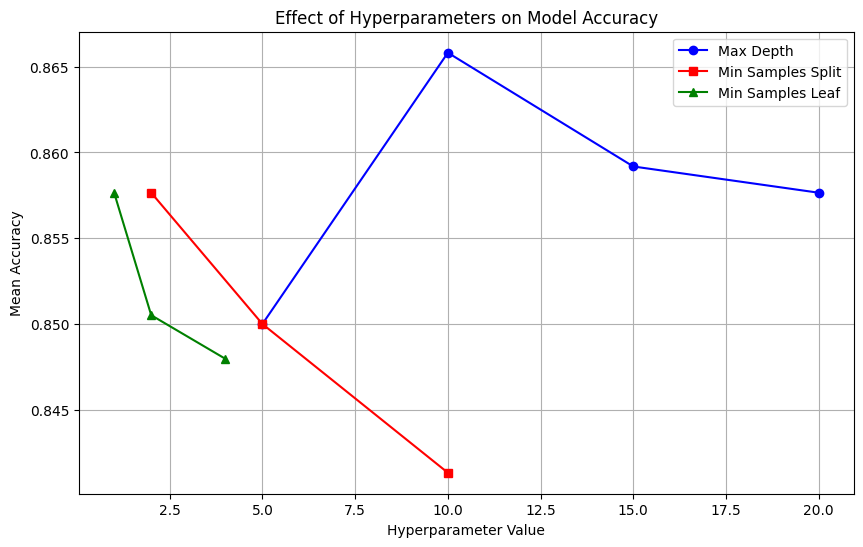

In [135]:
import numpy as np
import matplotlib.pyplot as plt

param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Function to compute mean accuracy for a given hyperparameter while keeping others unrestricted
def compute_mean_scores(param_name, param_values, fixed_params={}):
    mean_scores = []
    for value in param_values:
        indices = [i for i, params in enumerate(results['params'])
                   if params[param_name] == value and all(params[k] == v for k, v in fixed_params.items())]
        if indices:
            mean_accuracy = np.mean([results['mean_test_score'][i] for i in indices])
        else:
            mean_accuracy = np.nan  # Handle cases where no valid indices are found
        mean_scores.append(mean_accuracy)
    return mean_scores

# Define parameter values
max_depth_values = [d for d in param_grid['max_depth'] if d is not None]
min_samples_split_values = param_grid['min_samples_split']
min_samples_leaf_values = param_grid['min_samples_leaf']

# Compute accuracy scores while isolating each hyperparameter
mean_test_scores_max_depth = compute_mean_scores('max_depth', max_depth_values, {'min_samples_split': 2, 'min_samples_leaf': 1})
mean_test_scores_min_samples_split = compute_mean_scores('min_samples_split', min_samples_split_values, {'max_depth': None, 'min_samples_leaf': 1})
mean_test_scores_min_samples_leaf = compute_mean_scores('min_samples_leaf', min_samples_leaf_values, {'max_depth': None, 'min_samples_split': 2})

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, mean_test_scores_max_depth, marker='o', linestyle='-', label='Max Depth', color='b')
plt.plot(min_samples_split_values, mean_test_scores_min_samples_split, marker='s', linestyle='-', label='Min Samples Split', color='r')
plt.plot(min_samples_leaf_values, mean_test_scores_min_samples_leaf, marker='^', linestyle='-', label='Min Samples Leaf', color='g')

plt.xlabel('Hyperparameter Value')
plt.ylabel('Mean Accuracy')
plt.title('Effect of Hyperparameters on Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Este gráfico demuestran los hiperparámetros mejores y peores de max_depth, min_samples_split, y min_samples_leaf.

# Modelos Lineales y SVMs

Modelos Lineales:

In [137]:
from sklearn.linear_model import LogisticRegression
import time

# Initialize models
log_reg = LogisticRegression(penalty=None, random_state=559990)  # No regularization
lasso_log_reg = LogisticRegression(penalty="l1", solver="liblinear", random_state=559990)  # L1 Regularization

# Train Logistic Regression without L1
start_time = time.time()
log_reg.fit(X_train, y_train)
end_time = time.time()
log_reg_time = end_time - start_time
print(f"Training Time (Logistic Regression - No Regularization): {log_reg_time:.4f} seconds")

# Train Logistic Regression with L1 (Lasso)
start_time = time.time()
lasso_log_reg.fit(X_train, y_train)
end_time = time.time()
lasso_log_reg_time = end_time - start_time
print(f"Training Time (Lasso Logistic Regression - L1 Regularization): {lasso_log_reg_time:.4f} seconds")
print("--------------------------------------------------------------------------------------------------------")

# Evaluate models
print("\nLogistic Regression (No Regularization):")
evaluate_model_train(log_reg, X_train, y_train)
print("--------------------------------------------------------------------------------------------------------")
print("\nLasso Logistic Regression (L1 Regularization):")
evaluate_model_train(lasso_log_reg, X_train, y_train)


Training Time (Logistic Regression - No Regularization): 0.0216 seconds
Training Time (Lasso Logistic Regression - L1 Regularization): 0.0358 seconds
--------------------------------------------------------------------------------------------------------

Logistic Regression (No Regularization):
Balanced Accuracy (Train): 0.6301
Overall Accuracy (Train): 0.8597
True Positive Rate (TPR) (Train): 0.2911
True Negative Rate (TNR) (Train): 0.9690

Confusion Matrix (Train):
[[1593   51]
 [ 224   92]]

Classification Report (Train):
              precision    recall  f1-score   support

          No       0.88      0.97      0.92      1644
         Yes       0.64      0.29      0.40       316

    accuracy                           0.86      1960
   macro avg       0.76      0.63      0.66      1960
weighted avg       0.84      0.86      0.84      1960

--------------------------------------------------------------------------------------------------------

Lasso Logistic Regression (L1 Regul

En estas matrices de confusión, podemos ver una gran diferencia entre los porcentajes de TPR y TNR. Los datos demuestran que el rendimiento del modelo es mucho mejor para los casos de "No" que los casos de "Yes".

Entonces, vamos a realizar HPO para los modelos lineales usando GridSearch.

In [138]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the range of C values to test for hyperparameter tuning
param_grid = {'C': np.logspace(-4, 4, 10)}  # Log scale range from 10^-4 to 10^4

# Initialize GridSearchCV for Logistic Regression (No Regularization)
grid_search_log_reg = GridSearchCV(LogisticRegression(penalty=None, random_state=559990), param_grid, cv=5, n_jobs=-1)
start_time = time.time()
grid_search_log_reg.fit(X_train, y_train)
end_time = time.time()
log_reg_hpo_time = end_time - start_time
print(f"Training Time (GridSearchCV - Logistic Regression): {log_reg_hpo_time:.4f} seconds")

# Best model and its parameters
best_log_reg_model = grid_search_log_reg.best_estimator_
print(f"Best C (Logistic Regression - No Regularization): {grid_search_log_reg.best_params_}")

# Initialize GridSearchCV for Lasso Logistic Regression (L1 Regularization)
grid_search_lasso_log_reg = GridSearchCV(LogisticRegression(penalty="l1", solver="liblinear", random_state=559990), param_grid, cv=5, n_jobs=-1)
start_time = time.time()
grid_search_lasso_log_reg.fit(X_train, y_train)
end_time = time.time()
lasso_log_reg_hpo_time = end_time - start_time
print(f"Training Time (GridSearchCV - Lasso Logistic Regression): {lasso_log_reg_hpo_time:.4f} seconds")

# Best model and its parameters
best_lasso_log_reg_model = grid_search_lasso_log_reg.best_estimator_
print(f"Best C (Lasso Logistic Regression - L1 Regularization): {grid_search_lasso_log_reg.best_params_}")
print("--------------------------------------------------------------------------------------------------------")

# Evaluate the best models
print("\nLogistic Regression (No Regularization):")
evaluate_model_train(best_log_reg_model, X_train, y_train)
print("--------------------------------------------------------------------------------------------------------")
print("\nLasso Logistic Regression (L1 Regularization):")
evaluate_model_train(best_lasso_log_reg_model, X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Training Time (GridSearchCV - Logistic Regression): 0.9984 seconds
Best C (Logistic Regression - No Regularization): {'C': np.float64(0.0001)}
Training Time (GridSearchCV - Lasso Logistic Regression): 2.2387 seconds
Best C (Lasso Logistic Regression - L1 Regularization): {'C': np.float64(0.3593813663804626)}
--------------------------------------------------------------------------------------------------------

Logistic Regression (No Regularization):
Balanced Accuracy (Train): 0.6301
Overall Accuracy (Train): 0.8597
True Positive Rate (TPR) (Train): 0.2911
True Negative Rate (TNR) (Train): 0.9690

Confusion Matrix (Train):
[[1593   51]
 [ 224   92]]

Classification Report (Train):
              precision    recall  f1-score   support

          No       0.88      0.97      0.92      1644
         Yes       0.64      0.29      0.40       316

    accuracy                           0.86      1960
   macro avg       0.76      0.63      0.66      1960
weighted avg       0.84      0.86   

No hay una gran diferencia después de HPO.

Vamos a usar otro "threshold" para aumentar el TPR.

In [143]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, classification_report
import numpy as np

def evaluate_model_with_custom_threshold(model, X_train, y_train, threshold=0.5):
    """
    Evaluates a model with a custom threshold for classification (default 0.5).
    """
    # Convert 'No' to 0 and 'Yes' to 1 in y_train
    y_train_int = np.where(y_train == 'Yes', 1, 0)

    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_train)[:, 1]  # Probability of the positive class (1)

    # Apply custom threshold to predict classes
    y_pred_custom = (y_prob > threshold).astype(int)

    # Compute metrics using y_train_int (converted labels)
    balanced_acc = balanced_accuracy_score(y_train_int, y_pred_custom)  # Balanced Accuracy
    overall_acc = accuracy_score(y_train_int, y_pred_custom)  # Overall Accuracy
    cm = confusion_matrix(y_train_int, y_pred_custom)  # Confusion Matrix

    # Extract TPR (Sensitivity) and TNR (Specificity)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # Sensitivity (Recall for positive class)
    tnr = tn / (tn + fp)  # Specificity

    # Print results
    print(f"Balanced Accuracy (Train): {balanced_acc:.4f}")
    print(f"Overall Accuracy (Train): {overall_acc:.4f}")
    print(f"True Positive Rate (TPR) (Train): {tpr:.4f}")
    print(f"True Negative Rate (TNR) (Train): {tnr:.4f}")
    print("\nConfusion Matrix (Train):")
    print(cm)
    print("\nClassification Report (Train):")
    print(classification_report(y_train_int, y_pred_custom))  # Classification report

# Example: Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are defined, and your data is ready
log_reg_model = LogisticRegression(max_iter=1000)

# Train the model
log_reg_model.fit(X_train, y_train)

# Now use the function with a custom threshold
evaluate_model_with_custom_threshold(log_reg_model, X_train, y_train, threshold=0.4)


Balanced Accuracy (Train): 0.6725
Overall Accuracy (Train): 0.8602
True Positive Rate (TPR) (Train): 0.3956
True Negative Rate (TNR) (Train): 0.9495

Confusion Matrix (Train):
[[1561   83]
 [ 191  125]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1644
           1       0.60      0.40      0.48       316

    accuracy                           0.86      1960
   macro avg       0.75      0.67      0.70      1960
weighted avg       0.84      0.86      0.85      1960



Feature Importance:

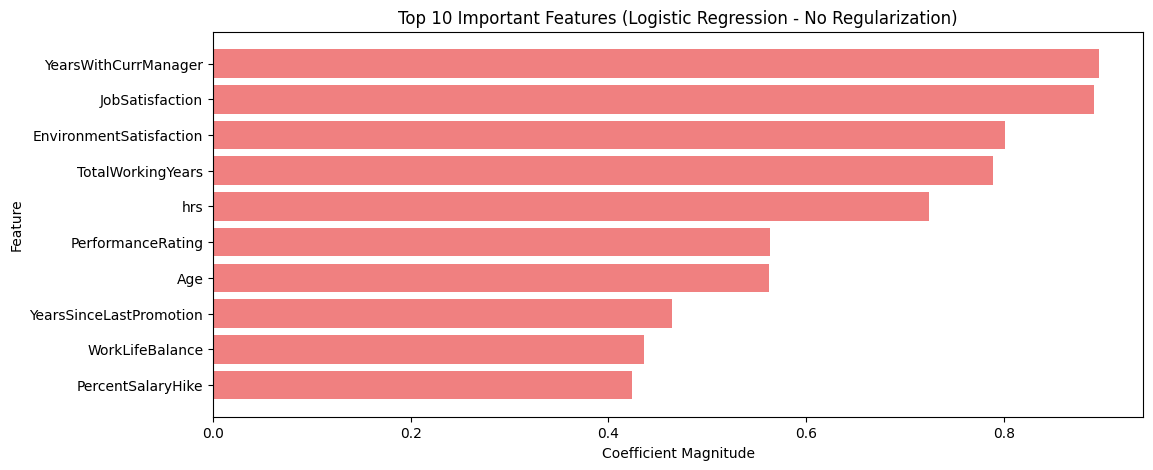

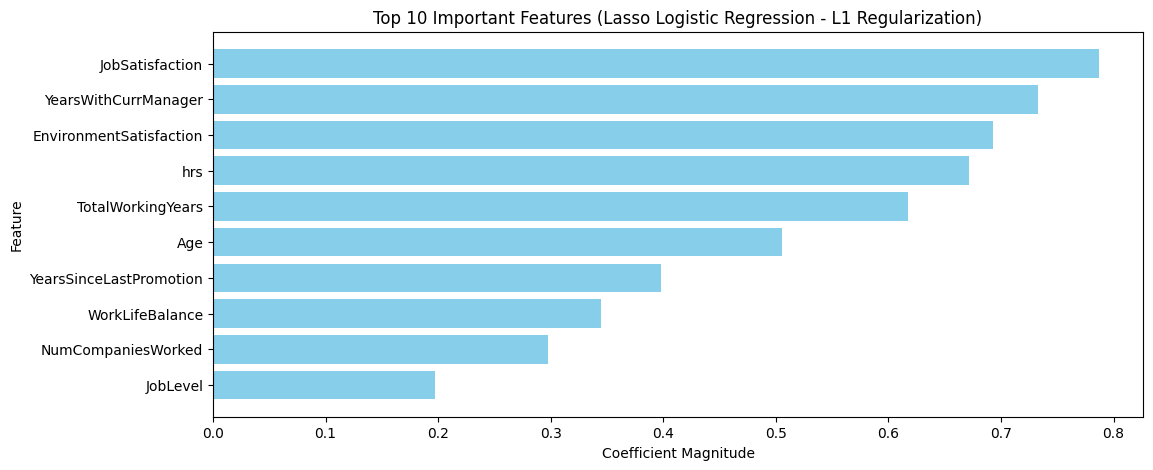

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure feature names are available
if isinstance(X_train, np.ndarray):
    feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]  # Generic names if NumPy array
else:
    feature_names = X_train.columns  # If Pandas DataFrame

# Extract coefficients
log_reg_coeffs = best_log_reg_model.coef_[0]  # No regularization
lasso_log_reg_coeffs = best_lasso_log_reg_model.coef_[0]  # L1 regularization

# Get absolute values for importance
log_reg_importance = np.abs(log_reg_coeffs)
lasso_log_reg_importance = np.abs(lasso_log_reg_coeffs)

# Match feature names with importance
feature_importance_log_reg = dict(zip(feature_names, log_reg_importance))
feature_importance_lasso_log_reg = dict(zip(feature_names, lasso_log_reg_importance))

# Sort features by importance (descending order)
sorted_log_reg_importance = sorted(feature_importance_log_reg.items(), key=lambda x: x[1], reverse=True)
sorted_lasso_log_reg_importance = sorted(feature_importance_lasso_log_reg.items(), key=lambda x: x[1], reverse=True)

# Select top 10 features for each model
top_features_log_reg = sorted_log_reg_importance[:10]
top_features_lasso_log_reg = sorted_lasso_log_reg_importance[:10]

# Convert to lists for plotting
features_log, importance_log = zip(*top_features_log_reg)
features_lasso, importance_lasso = zip(*top_features_lasso_log_reg)

# Plot Logistic Regression (No Regularization)
plt.figure(figsize=(12, 5))
plt.barh(features_log, importance_log, color='lightcoral')
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Logistic Regression - No Regularization)")
plt.gca().invert_yaxis()
plt.show()

# Plot Lasso Logistic Regression (L1 Regularization)
plt.figure(figsize=(12, 5))
plt.barh(features_lasso, importance_lasso, color='skyblue')
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Lasso Logistic Regression - L1 Regularization)")
plt.gca().invert_yaxis()
plt.show()


SVMs:

# Resultados y Modelo Final

# Tarea de Elección Abierta

Random Forest: Elegimos este modelo para nuestra tarea de elección abierta porque Random Forest es una buena opcion para evitar "overfitting," que es un problema que enfrentamos mucho a través de la práctica.


Evaluating Model on Training Data:
Balanced Accuracy (Train): 0.9740
Overall Accuracy (Train): 0.9915
True Positive Rate (TPR) (Train): 0.9479
True Negative Rate (TNR) (Train): 1.0000

Confusion Matrix (Train):
[[1968    0]
 [  20  364]]

Classification Report (Train):
              precision    recall  f1-score   support

          No       0.99      1.00      0.99      1968
         Yes       1.00      0.95      0.97       384

    accuracy                           0.99      2352
   macro avg       0.99      0.97      0.98      2352
weighted avg       0.99      0.99      0.99      2352





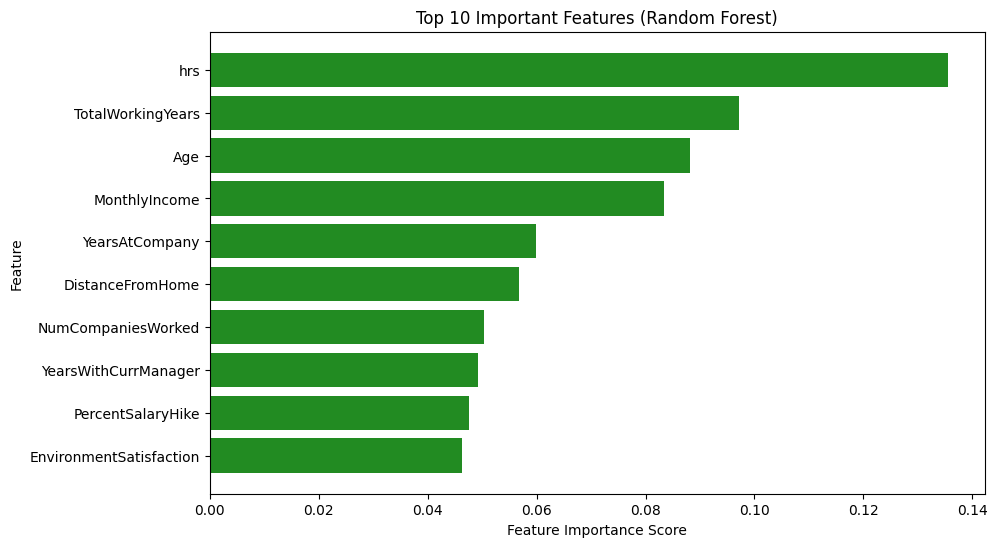

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame

# Filter out only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Select the feature variables (X) and target variable (y)
X = df[numerical_columns]
y = df['Attrition']  # 'Attrition' is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=559990)

# Create a pipeline with scaling and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('rf', RandomForestClassifier(max_depth=12, random_state=559990))  # Random Forest Classifier
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = pipeline.predict(X_train)

# Evaluate the model on the training set using your evaluate_model_train function
print("\nEvaluating Model on Training Data:")
evaluate_model_train(pipeline, X_train, y_train)

# Feature importance
importances = pipeline.named_steps['rf'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualize top 10 important features
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(10)
plt.barh(top_features['Feature'], top_features['Importance'], color='forestgreen')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
print("\n")
plt.show()


# Declaración de la IA

Una gran contribución de la IA en esta práctica es la herramienta de "dubugging" que oferece.